# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Patuh Rujhan Al Istizhar
- **Email:** patuh41@gmail.com
- **ID Dicoding:** patuh_istizhar

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Import Semua Packages/Library yang Digunakan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance
import kagglehub
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from sklearn.metrics import confusion_matrix, classification_report
import shutil
import random
import time
import datetime
import json

## Data Preparation

In [62]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

### Data Loading

In [63]:
# Download latest version
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Path to dataset files:", path)

Path to dataset files: /home/patuh/.cache/kagglehub/datasets/sumn2u/garbage-classification-v2/versions/8


In [64]:
# Define base directory for the dataset
base_dir = os.path.join(path, "garbage-dataset")
print("Classes in dataset:", os.listdir(base_dir))

Classes in dataset: ['trash', 'battery', 'plastic', 'metal', 'cardboard', 'clothes', 'glass', 'paper', 'shoes', 'biological']


DataFrame sample:
                                           filepaths   labels
0  /home/patuh/.cache/kagglehub/datasets/sumn2u/g...  battery
1  /home/patuh/.cache/kagglehub/datasets/sumn2u/g...  battery
2  /home/patuh/.cache/kagglehub/datasets/sumn2u/g...  battery
3  /home/patuh/.cache/kagglehub/datasets/sumn2u/g...  battery
4  /home/patuh/.cache/kagglehub/datasets/sumn2u/g...  battery

Class distribution:
labels
clothes       5327
glass         3061
plastic       1984
shoes         1977
cardboard     1825
paper         1680
metal         1020
biological     997
trash          947
battery        944
Name: count, dtype: int64


/tmp/ipykernel_25786/1905017917.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


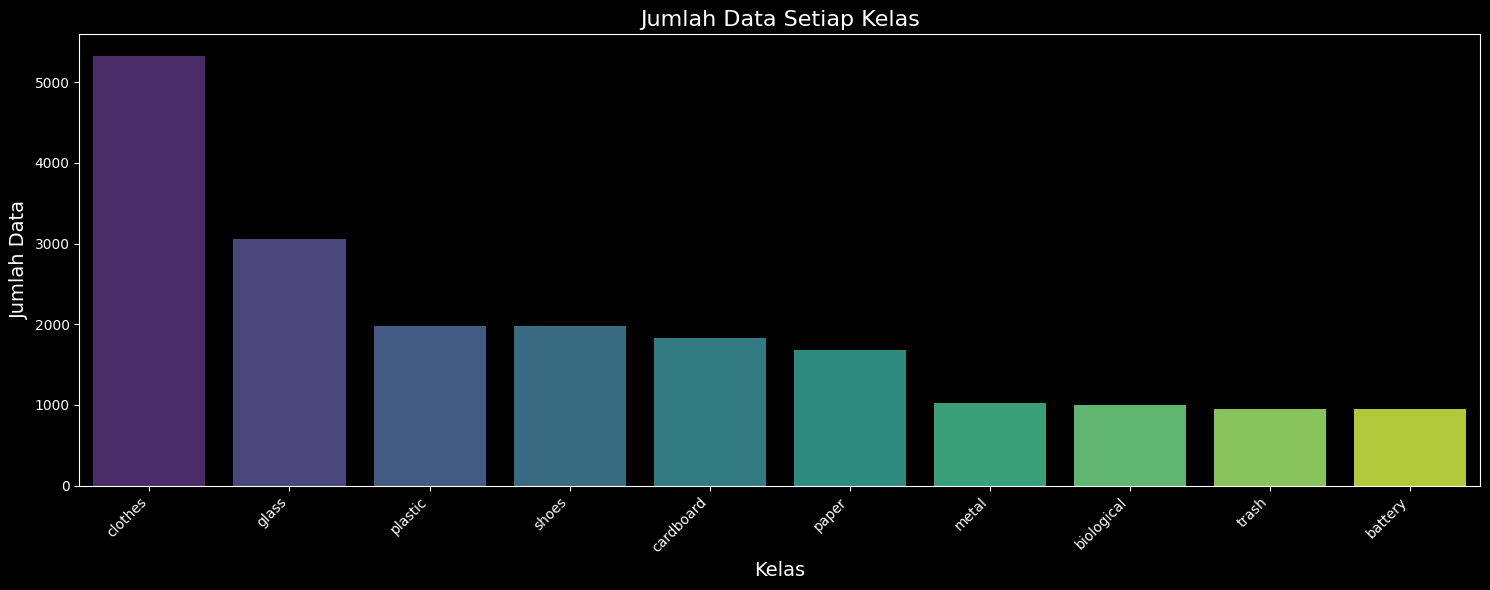

In [65]:
# Create dataframe with filepaths and labels
filepaths = []
labels = []
classlist = sorted(os.listdir(base_dir))

for klass in classlist:
    classpath = os.path.join(base_dir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)

print("DataFrame sample:")
print(df.head())

print("\nClass distribution:")
class_counts = df["labels"].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(15, 6))
# Modified this section to only show class distribution, removed the single bar chart
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Jumlah Data Setiap Kelas", fontsize=16)
plt.xlabel("Kelas", fontsize=14)
plt.ylabel("Jumlah Data", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing images...
Processed 100/19762 images...
Processed 200/19762 images...
Processed 300/19762 images...
Processed 400/19762 images...
Processed 500/19762 images...
Processed 600/19762 images...
Processed 700/19762 images...
Processed 800/19762 images...
Processed 900/19762 images...
Processed 1000/19762 images...
Processed 1100/19762 images...
Processed 1200/19762 images...
Processed 1300/19762 images...
Processed 1400/19762 images...
Processed 1500/19762 images...
Processed 1600/19762 images...
Processed 1700/19762 images...
Processed 1800/19762 images...
Processed 1900/19762 images...
Processed 2000/19762 images...
Processed 2100/19762 images...
Processed 2200/19762 images...
Processed 2300/19762 images...
Processed 2400/19762 images...
Processed 2500/19762 images...
Processed 2600/19762 images...
Processed 2700/19762 images...
Processed 2800/19762 images...
Processed 2900/19762 images...
Processed 3000/19762 images...
Processed 3100/19762 images...
Processed 3200/19762 ima

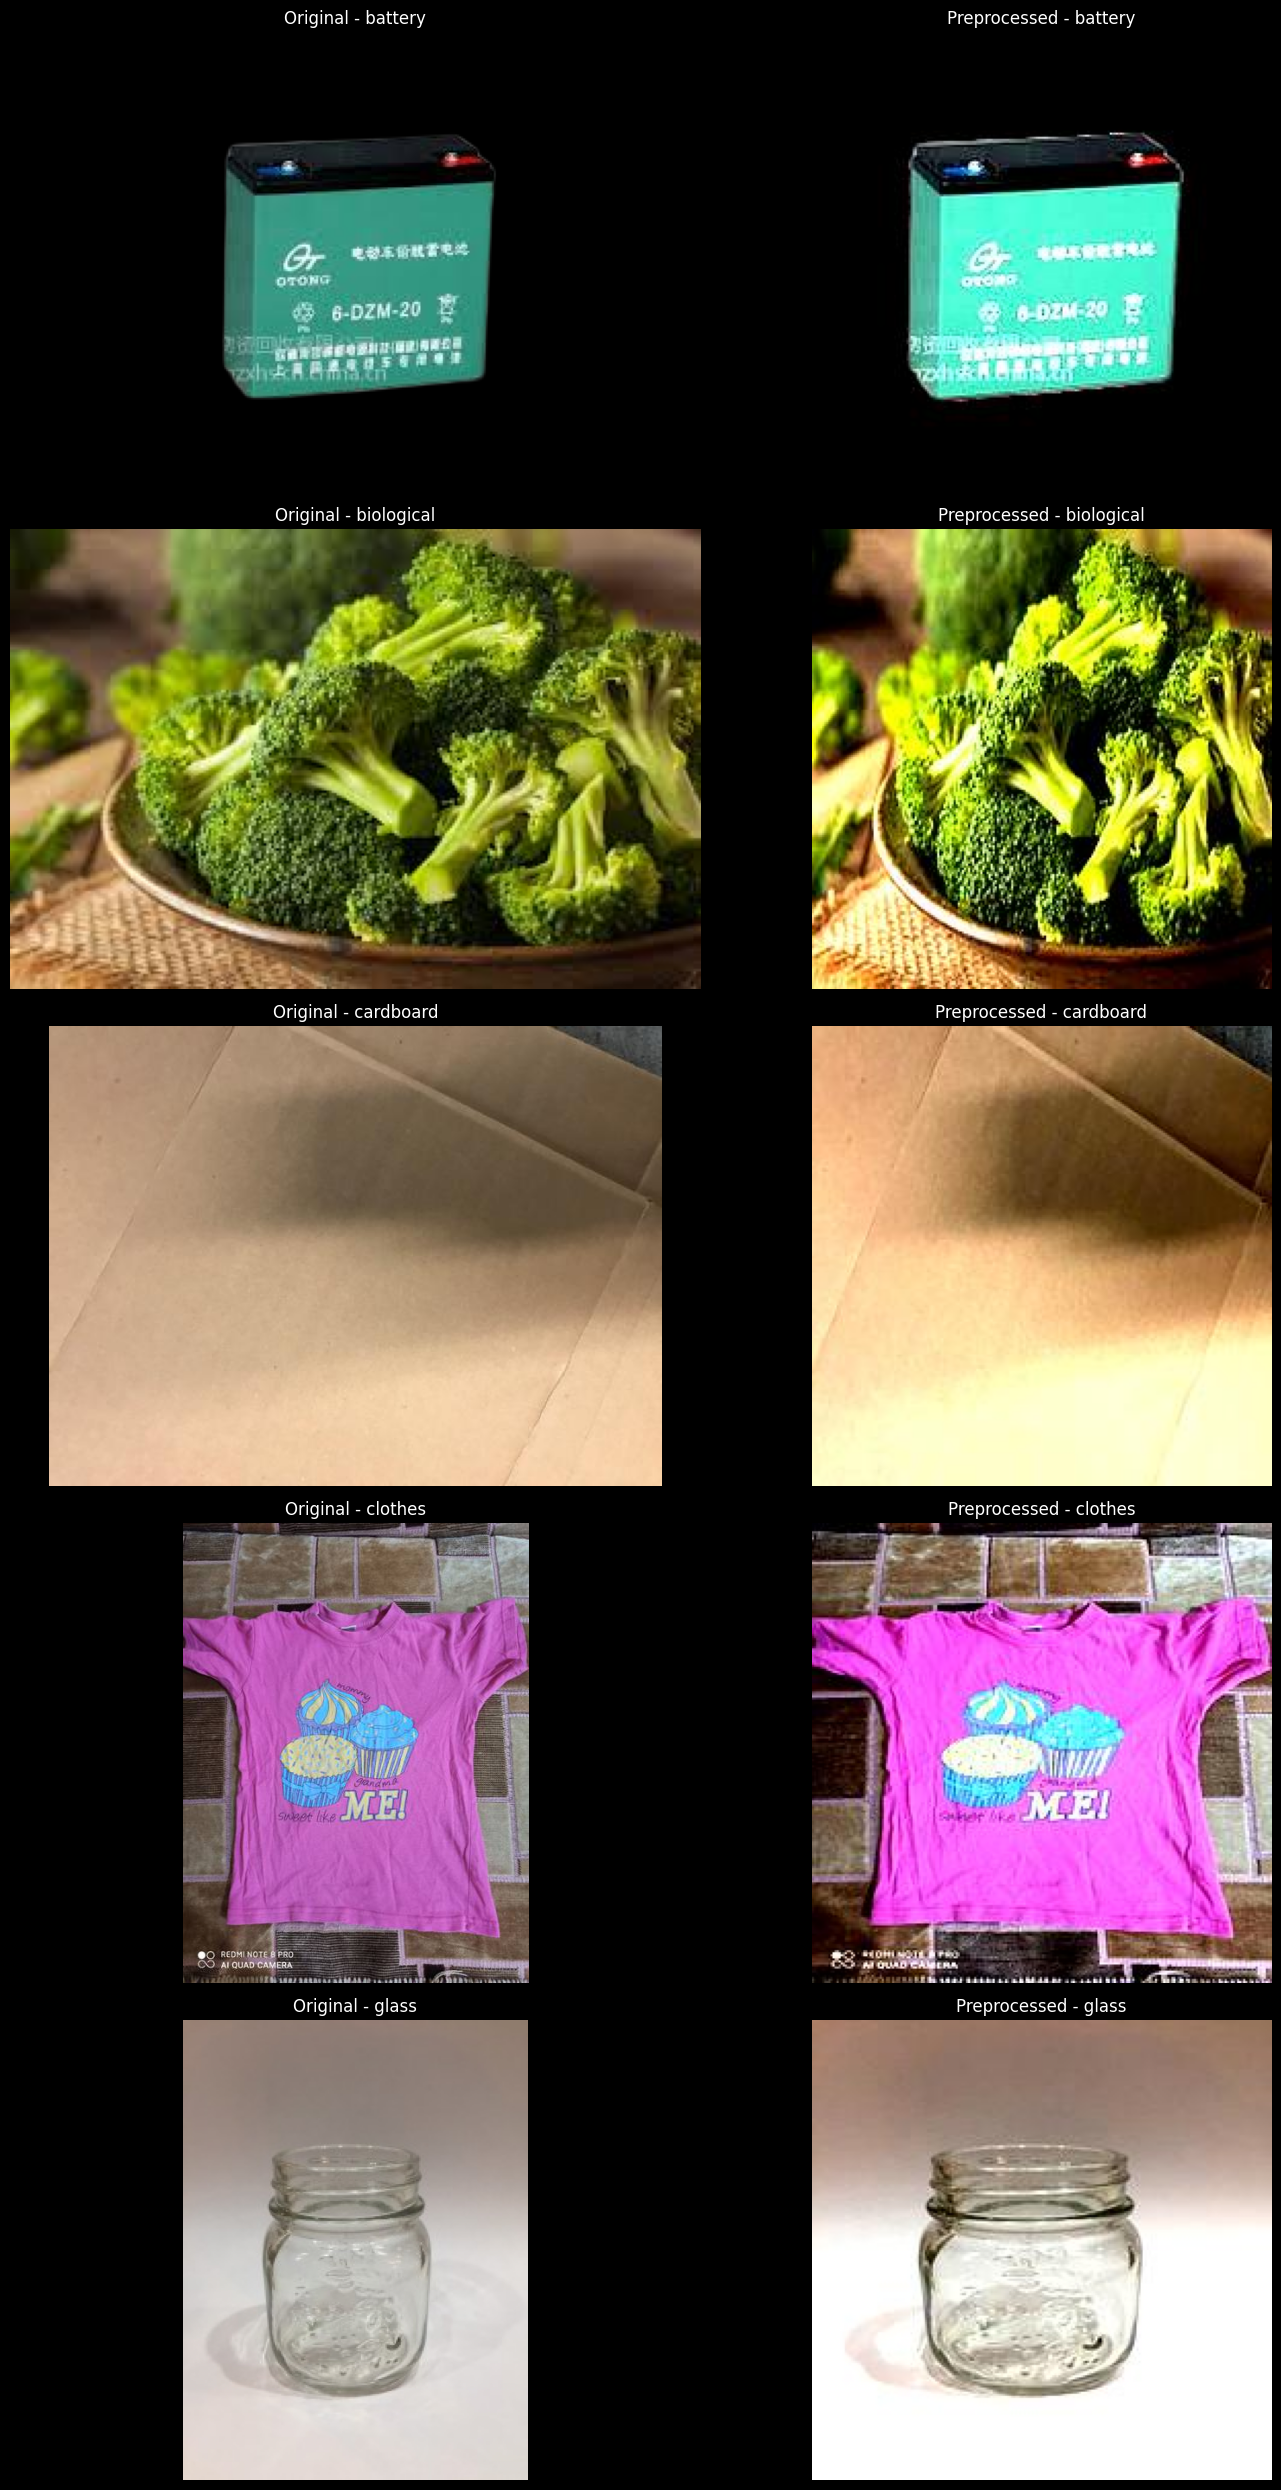

In [ ]:
# Create a directory for preprocessed images
preprocessed_dir = "preprocessed_dataset"
if os.path.exists(preprocessed_dir):
    shutil.rmtree(preprocessed_dir)
os.makedirs(preprocessed_dir)

# Create class directories
for class_name in classlist:
    os.makedirs(os.path.join(preprocessed_dir, class_name), exist_ok=True)


# Function to preprocess images (using PIL instead of cv2)
def preprocess_image(img_path, target_size=(IMG_SIZE, IMG_SIZE)):
    try:
        # Read image with PIL
        img = Image.open(img_path)

        # Resize image
        img = img.resize(target_size, Image.LANCZOS)

        # Convert to RGB (handle grayscale or RGBA images)
        if img.mode != "RGB":
            img = img.convert("RGB")

        # Apply basic preprocessing
        # 1. Enhance contrast
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)  # Increase contrast

        # 2. Enhance brightness
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(1.2)  # Slightly increase brightness

        # 3. Enhance sharpness
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(1.5)  # Increase sharpness

        return img

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None


# Process images and save them to the preprocessed directory
print("Preprocessing images...")
total_images = len(df)
processed_count = 0
error_count = 0

for _, row in df.iterrows():
    img_path = row["filepaths"]
    label = row["labels"]

    # Preprocess the image
    processed_img = preprocess_image(img_path)

    if processed_img is not None:
        # Generate output filename
        img_filename = os.path.basename(img_path)
        output_path = os.path.join(preprocessed_dir, label, img_filename)

        # Save the processed image
        processed_img.save(output_path)
        processed_count += 1
    else:
        error_count += 1

    # Print progress
    if processed_count % 100 == 0:
        print(f"Processed {processed_count}/{total_images} images...")

print(
    f"Preprocessing complete! {processed_count} images processed, {error_count} errors."
)


# Display examples of original vs preprocessed images
def display_comparison(original_paths, processed_dir, num_examples=3):
    plt.figure(figsize=(15, 5 * num_examples))

    for i, orig_path in enumerate(original_paths[:num_examples]):
        # Original image
        orig_img = Image.open(orig_path)

        # Preprocessed image
        label = os.path.basename(os.path.dirname(orig_path))
        img_filename = os.path.basename(orig_path)
        proc_path = os.path.join(processed_dir, label, img_filename)

        if os.path.exists(proc_path):
            proc_img = Image.open(proc_path)

            # Display images
            plt.subplot(num_examples, 2, 2 * i + 1)
            plt.imshow(orig_img)
            plt.title(f"Original - {label}", fontsize=12)
            plt.axis("off")

            plt.subplot(num_examples, 2, 2 * i + 2)
            plt.imshow(proc_img)
            plt.title(f"Preprocessed - {label}", fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()


# Show some examples
sample_images = []
for class_name in classlist:
    class_samples = df[df["labels"] == class_name]["filepaths"].sample(
        min(1, sum(df["labels"] == class_name))
    )
    sample_images.extend(class_samples.tolist())

display_comparison(
    sample_images, preprocessed_dir, num_examples=min(5, len(sample_images))
)

#### Split Dataset

Copying files: 19762 files [00:16, 1169.10 files/s]


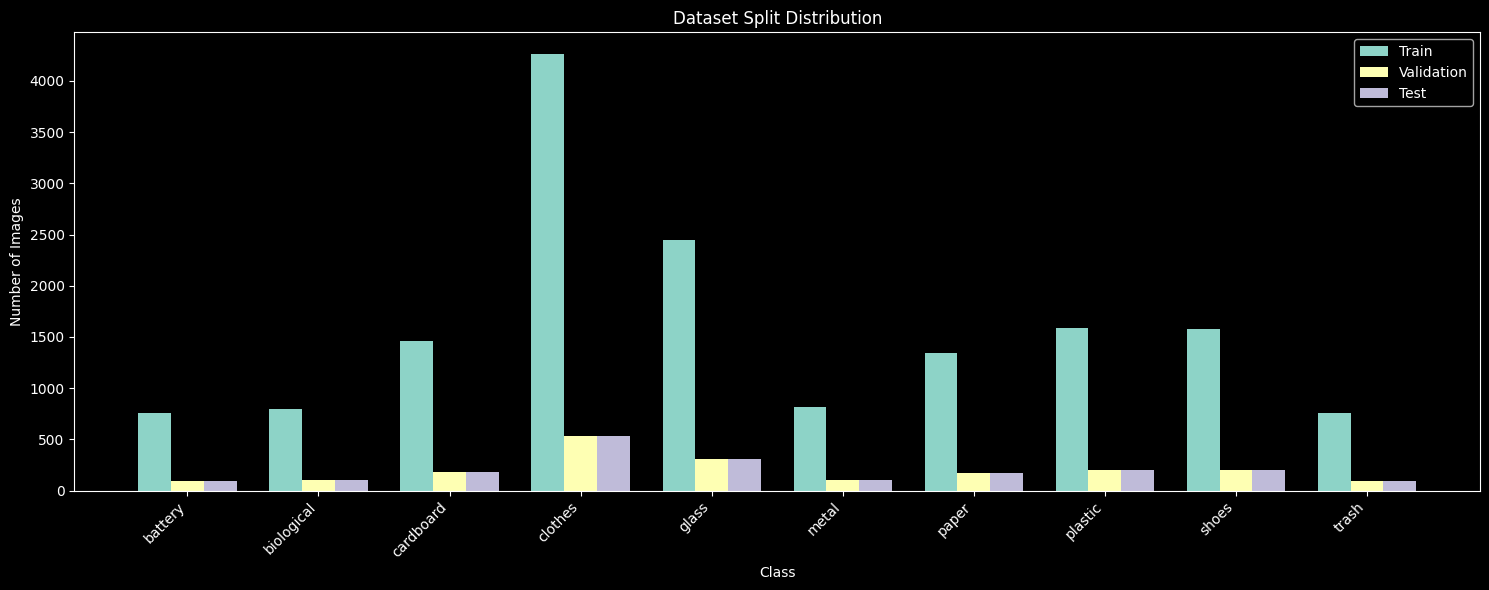

Train set: 15806 images
Validation set: 1972 images
Test set: 1984 images
Found 15806 images belonging to 10 classes.
Found 1972 images belonging to 10 classes.
Found 1984 images belonging to 10 classes.
Class indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}
Number of classes: 10


In [ ]:
output_folder = "split_dataset"

# Remove output folder if it exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Split the preprocessed dataset
splitfolders.ratio(
    preprocessed_dir, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1)
)

# Verify the split
train_dir = os.path.join(output_folder, "train")
val_dir = os.path.join(output_folder, "val")
test_dir = os.path.join(output_folder, "test")

train_counts = []
val_counts = []
test_counts = []
class_names = []

for class_name in classlist:
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    if (
        os.path.exists(train_class_dir)
        and os.path.exists(val_class_dir)
        and os.path.exists(test_class_dir)
    ):
        train_count = len(os.listdir(train_class_dir))
        val_count = len(os.listdir(val_class_dir))
        test_count = len(os.listdir(test_class_dir))

        train_counts.append(train_count)
        val_counts.append(val_count)
        test_counts.append(test_count)
        class_names.append(class_name)

# Plot the split distribution
plt.figure(figsize=(15, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, train_counts, width, label="Train")
plt.bar(x, val_counts, width, label="Validation")
plt.bar(x + width, test_counts, width, label="Test")

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Dataset Split Distribution")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Train set: {sum(train_counts)} images")
print(f"Validation set: {sum(val_counts)} images")
print(f"Test set: {sum(test_counts)} images")

# Create data generators
train_datagen = ImageDataGenerator(
    # We already preprocessed images, but apply augmentation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest",
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

# Display class indices
print(f"Class indices: {train_generator.class_indices}")
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

# Save class indices for later
class_indices = train_generator.class_indices
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

# Create a dictionary mapping indices to class labels
idx_to_class = {v: k for k, v in class_indices.items()}

## Modelling

In [ ]:
# Create Sequential model
def create_model(input_shape, num_classes):
    model = Sequential(
        [
            # First convolutional block
            Conv2D(
                32, (3, 3), activation="relu", padding="same", input_shape=input_shape
            ),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Second convolutional block
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Third convolutional block
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Fourth convolutional block
            Conv2D(256, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Flatten and fully connected layers
            Flatten(),
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation="softmax"),
        ]
    )

    return model


# Create model
model = create_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
model.summary()

# Configure learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9
)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Set up callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ModelCheckpoint(
        "best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
]

# Train the model
print("\nTraining model...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Found 15806 images belonging to 10 classes.
Found 1972 images belonging to 10 classes.


## Evaluasi dan Visualisasi

In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")

# Extract training history
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot training & validation accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.axhline(y=0.95, color="r", linestyle="--", label="Target (95%)")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Print best accuracy values
best_val_acc = max(val_acc)
best_train_acc = max(train_acc)
print(f"\nBest Training Accuracy: {best_train_acc:.4f} ({best_train_acc * 100:.2f}%)")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc * 100:.2f}%)")

# Check if target accuracy is achieved
if best_train_acc < 0.95 or test_acc < 0.95:
    print("\nWARNING: Target accuracy of 95% not achieved!")
    print("Consider adjusting model architecture or training parameters.")
else:
    print("\nSUCCESS: Target accuracy of 95% achieved for both training and test sets!")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(class_indices.keys()),
    yticklabels=list(class_indices.keys()),
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(
    classification_report(
        y_true, y_pred_classes, target_names=list(class_indices.keys())
    )
)


# Display some example predictions
def display_predictions(generator, model, class_indices, num_images=10):
    # Get class labels
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Get batch of images
    batch = next(generator)
    images, labels = batch

    # Make predictions
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    # Display images with predictions
    plt.figure(figsize=(15, num_images * 2))

    for i in range(min(num_images, len(images))):
        plt.subplot(num_images // 2, 2, i + 1)
        plt.imshow(images[i])

        # Check if prediction is correct
        is_correct = pred_classes[i] == true_classes[i]
        color = "green" if is_correct else "red"

        # Get class names
        pred_class_name = idx_to_class[pred_classes[i]]
        true_class_name = idx_to_class[true_classes[i]]

        plt.title(
            f"Prediction: {pred_class_name}\nTrue: {true_class_name}",
            color=color,
            fontsize=12,
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Display some test predictions
test_batch_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=10,
    class_mode="categorical",
    shuffle=True,
)
display_predictions(test_batch_generator, model, class_indices)

## Konversi Model

In [ ]:
# Konversi Model
print("\n=== KONVERSI MODEL ===")

# 1. Save model in SavedModel format
savedmodel_path = "savedmodel"
tf.saved_model.save(model, savedmodel_path)
print(f"Model saved in SavedModel format at: {savedmodel_path}")


# 2. Convert to TensorFlow Lite
def convert_to_tflite(model, quantize=False):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    # Save the TFLite model
    model_name = "model_quantized.tflite" if quantize else "model.tflite"
    with open(model_name, "wb") as f:
        f.write(tflite_model)

    print(f"TFLite model saved as: {model_name}")
    return tflite_model


# Convert to TFLite (standard)
tflite_model = convert_to_tflite(model)

# Convert to TFLite (quantized)
tflite_model_quantized = convert_to_tflite(model, quantize=True)

# 3. Convert to TensorFlow.js format
tfjs_path = "tfjs_model"
if os.path.exists(tfjs_path):
    shutil.rmtree(tfjs_path)

# The conversion requires tensorflowjs package
# Install it if needed: !pip install tensorflowjs
try:
    import tensorflowjs as tfjs

    tfjs.converters.save_keras_model(model, tfjs_path)
    print(f"TensorFlow.js model saved at: {tfjs_path}")
except ImportError:
    print("tensorflowjs package not found. Install with: pip install tensorflowjs")


## Inference (Optional)

In [ ]:
print("\n=== INFERENCE ===")


def load_and_preprocess_image(image_path):
    # Load the image with PIL
    img = Image.open(image_path)

    # Convert to RGB if needed
    if img.mode != "RGB":
        img = img.convert("RGB")

    # Resize the image
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

    # Convert to numpy array and normalize
    img_array = np.array(img) / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img_array


def predict_image(model, image_path, class_indices):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get class name
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_class = idx_to_class[predicted_class_index]

    # Get confidence
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence, predictions[0]


# Select a few test images
test_images = []
for class_name in classlist:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(class_dir):
        # Get list of files
        files = os.listdir(class_dir)
        if files:
            # Select one random file
            test_image = os.path.join(class_dir, random.choice(files))
            test_images.append((test_image, class_name))

# Perform inference on the test images
for image_path, true_class in test_images:
    predicted_class, confidence, all_scores = predict_image(
        model, image_path, class_indices
    )

    # Print results
    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

    # Display image with prediction
    img = Image.open(image_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    color = "green" if predicted_class == true_class else "red"
    plt.title(
        f"Prediction: {predicted_class} ({confidence:.2%})\nTrue: {true_class}",
        color=color,
        fontsize=14,
    )
    plt.axis("off")
    plt.show()

    # Display probability distribution
    plt.figure(figsize=(10, 3))
    plt.bar(list(class_indices.keys()), all_scores)
    plt.title("Class Probabilities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

print("\nGarbage Classification Model Pipeline Complete!")